In [2]:
import pandas as pd

# Load the data from the uploaded CSV file
data = pd.read_csv('/content/uber.csv')

# Display the first few rows of the dataset to understand its structure and contents
data.head()


,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


#handling Missing Values

In [3]:
# Analyze missing values in the dataset
missing_values_analysis = data.isnull().sum()

# Descriptive statistics for 'fare_amount' to understand its distribution and identify outliers
fare_amount_stats = data['fare_amount'].describe()

# Determine outlier bounds for 'fare_amount' based on the IQR (Interquartile Range) method
Q1 = fare_amount_stats['25%']
Q3 = fare_amount_stats['75%']
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Summary of the analysis
missing_values_analysis, fare_amount_stats, lower_bound, upper_bound


(Unnamed: 0           0
 key                  0
 fare_amount          0
 pickup_datetime      0
 pickup_longitude     0
 pickup_latitude      0
 dropoff_longitude    1
 dropoff_latitude     1
 passenger_count      0
 dtype: int64,
 count    200000.000000
 mean         11.359955
 std           9.901776
 min         -52.000000
 25%           6.000000
 50%           8.500000
 75%          12.500000
 max         499.000000
 Name: fare_amount, dtype: float64,
 -3.75,
 22.25)

#handling Outliers

In [4]:
# Adjusting the outlier handling based on the data's characteristics
# Set the lower bound to 0 and the upper bound to 100 for fare_amount
adjusted_lower_bound = 0
adjusted_upper_bound = 100

# Removing rows with fare_amount outside the adjusted bounds and missing values in critical columns
cleaned_data = data[
    (data['fare_amount'] >= adjusted_lower_bound) &
    (data['fare_amount'] <= adjusted_upper_bound)
].dropna(subset=['dropoff_longitude', 'dropoff_latitude'])

# Check the shape of the data after cleaning to ensure rows are removed appropriately
cleaned_data_shape = cleaned_data.shape

cleaned_data_shape


(199898, 9)

#Normalization and Standardization

In [5]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Standardization (if required)
scaler = StandardScaler()
cleaned_data['fare_amount_standardized'] = scaler.fit_transform(cleaned_data[['fare_amount']])

# Normalization (if required)
min_max_scaler = MinMaxScaler()
cleaned_data['fare_amount_normalized'] = min_max_scaler.fit_transform(cleaned_data[['fare_amount']])


#EDA

In [6]:
import numpy as np
import pandas as pd
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import seaborn as sns


# Distribution of Fare Amount

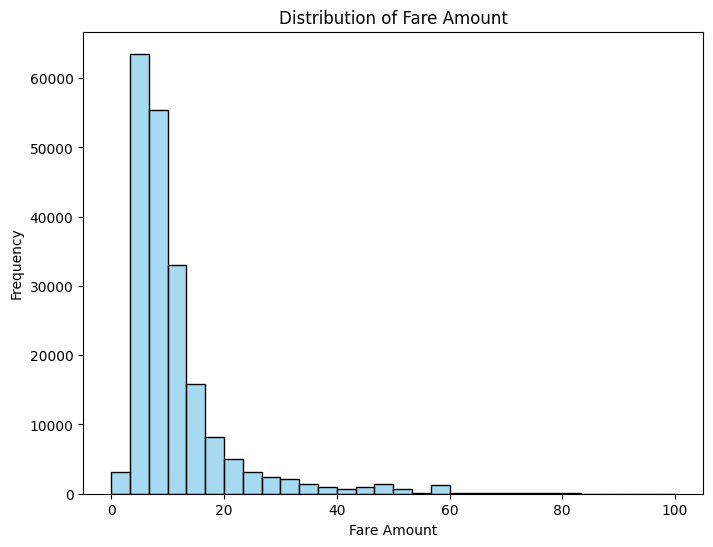

In [7]:
plt.figure(figsize=(8, 6))
sns.histplot(cleaned_data['fare_amount'], bins=30, color='skyblue')
plt.title('Distribution of Fare Amount')
plt.xlabel('Fare Amount')
plt.ylabel('Frequency')
plt.show()


# Distribution of Passenger Count

<ipython-input-8-7ca6546c7a83>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='passenger_count', data=cleaned_data, palette='viridis')


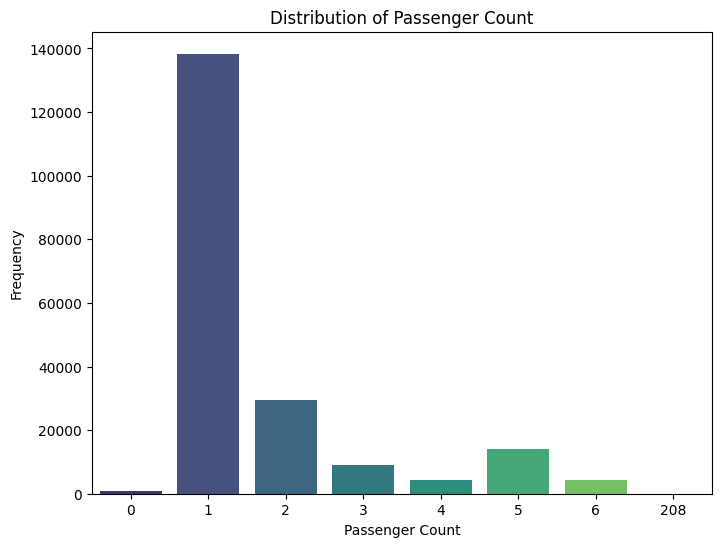

In [8]:
plt.figure(figsize=(8, 6))
sns.countplot(x='passenger_count', data=cleaned_data, palette='viridis')
plt.title('Distribution of Passenger Count')
plt.xlabel('Passenger Count')
plt.ylabel('Frequency')
plt.show()


In [12]:
# Validate coordinate data before calculating distance
cleaned_data = cleaned_data[
    (cleaned_data['pickup_latitude'].between(-90, 90)) &
    (cleaned_data['pickup_longitude'].between(-180, 180)) &
    (cleaned_data['dropoff_latitude'].between(-90, 90)) &
    (cleaned_data['dropoff_longitude'].between(-180, 180))
]

# Function to calculate the distance using geodesic, ensuring the order is (latitude, longitude)
def calculate_distance(row):
    pickup = (row['pickup_latitude'], row['pickup_longitude'])
    dropoff = (row['dropoff_latitude'], row['dropoff_longitude'])
    return geodesic(pickup, dropoff).miles

# Calculate 'trip_distance' only if it doesn't already exist in the DataFrame
if 'trip_distance' not in cleaned_data.columns:
    cleaned_data['trip_distance'] = cleaned_data.apply(calculate_distance, axis=1)


<ipython-input-12-a2780b4d7f5e>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['trip_distance'] = cleaned_data.apply(calculate_distance, axis=1)


#Fare Amount vs. Trip Distance

<ipython-input-13-d187f1a9cfa6>:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='trip_distance', y='fare_amount', data=cleaned_data, palette='coolwarm')


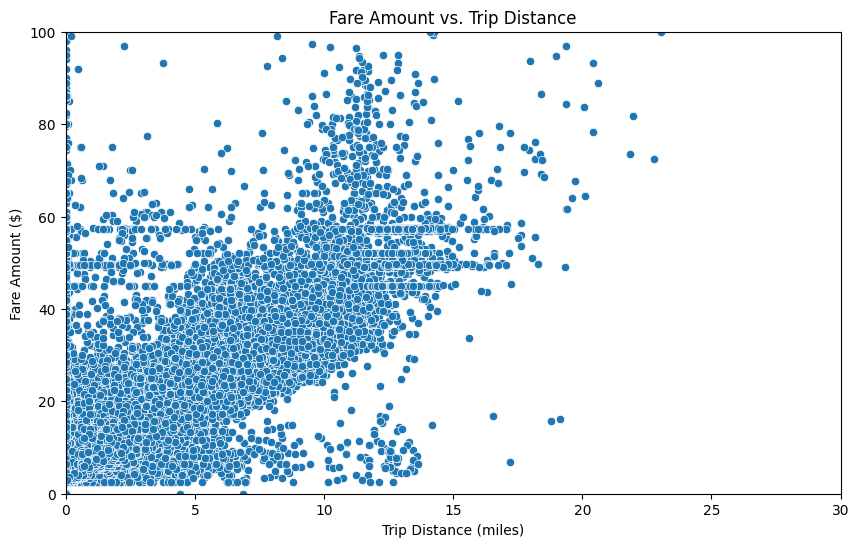

In [13]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='trip_distance', y='fare_amount', data=cleaned_data, palette='coolwarm')
plt.title('Fare Amount vs. Trip Distance')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Fare Amount ($)')
plt.xlim(0, 30)  # Limiting x-axis to focus on common trip distances
plt.ylim(0, 100)  # Limiting y-axis to focus on common fare amounts
plt.show()


#Fare Amount by Hour of Day

<ipython-input-14-12e704f5b3e2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['pickup_datetime'] = pd.to_datetime(cleaned_data['pickup_datetime'])
<ipython-input-14-12e704f5b3e2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['pickup_hour'] = cleaned_data['pickup_datetime'].dt.hour
<ipython-input-14-12e704f5b3e2>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` fo

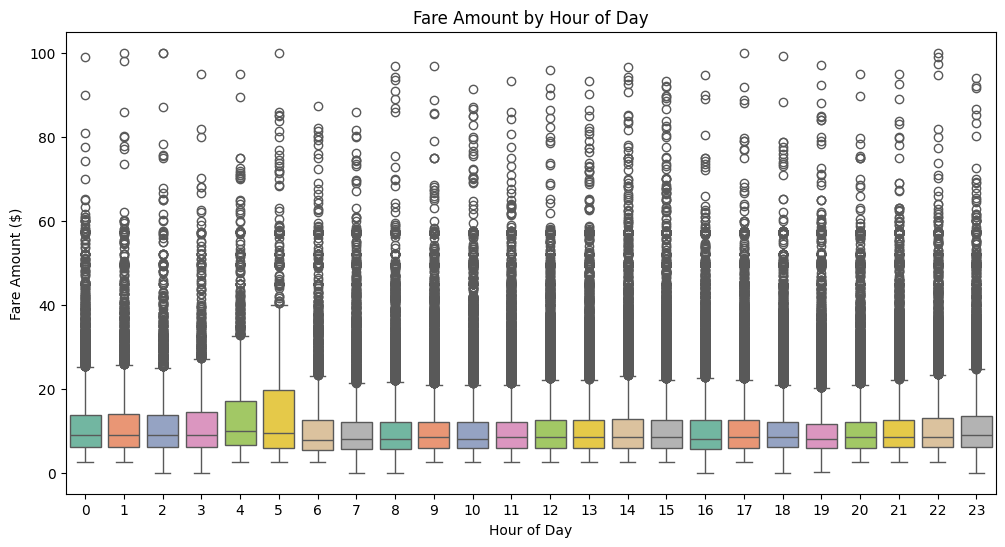

In [14]:
# Ensure 'pickup_datetime' is a datetime column if not already done
cleaned_data['pickup_datetime'] = pd.to_datetime(cleaned_data['pickup_datetime'])

# Create 'pickup_hour' from 'pickup_datetime'
cleaned_data['pickup_hour'] = cleaned_data['pickup_datetime'].dt.hour

# Now plot Fare Amount by Hour of Day
plt.figure(figsize=(12, 6))
sns.boxplot(x='pickup_hour', y='fare_amount', data=cleaned_data, palette='Set2')
plt.title('Fare Amount by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Fare Amount ($)')
plt.show()


#Fare Amount Variation by Day of the Week

<ipython-input-15-ccdfeb0ebd57>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['pickup_datetime'] = pd.to_datetime(cleaned_data['pickup_datetime'])
<ipython-input-15-ccdfeb0ebd57>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['day_of_week'] = cleaned_data['pickup_datetime'].dt.day_name()
<ipython-input-15-ccdfeb0ebd57>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=Fal

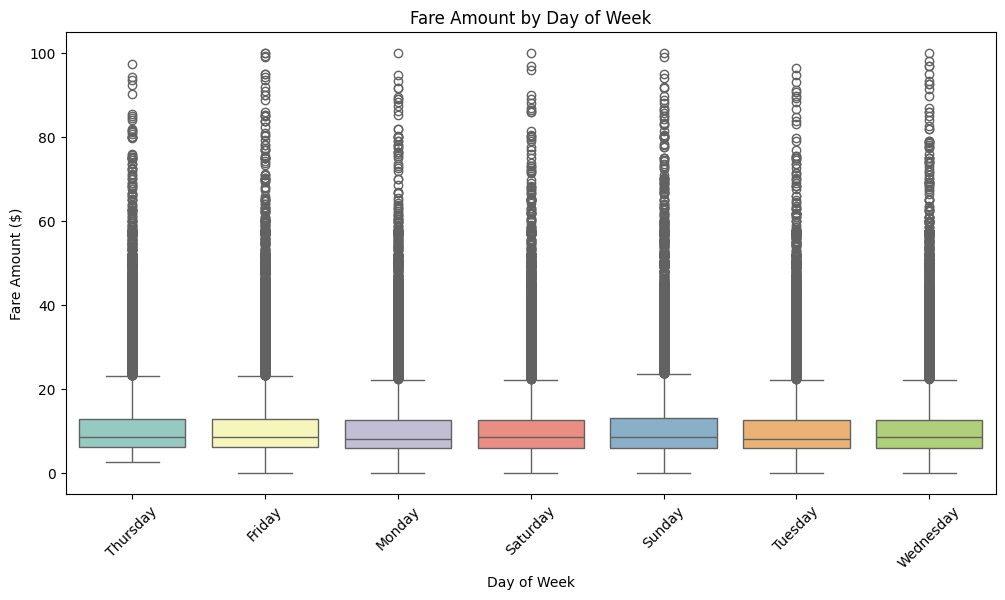

In [15]:
# Ensure 'pickup_datetime' is in datetime format if this step was missed
cleaned_data['pickup_datetime'] = pd.to_datetime(cleaned_data['pickup_datetime'])

# Create 'day_of_week' from 'pickup_datetime'
cleaned_data['day_of_week'] = cleaned_data['pickup_datetime'].dt.day_name()

# Now plot Fare Amount by Day of Week
plt.figure(figsize=(12, 6))
sns.boxplot(x='day_of_week', y='fare_amount', data=cleaned_data, palette='Set3')
plt.title('Fare Amount by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Fare Amount ($)')
plt.xticks(rotation=45)  # To improve label readability
plt.show()


#Feature Engineering for Uber Fare Prediction

#Trip Distance

In [16]:
from geopy.distance import geodesic

def calculate_distance(row):
    pickup = (row['pickup_latitude'], row['pickup_longitude'])
    dropoff = (row['dropoff_latitude'], row['dropoff_longitude'])
    return geodesic(pickup, dropoff).miles

cleaned_data['trip_distance'] = cleaned_data.apply(calculate_distance, axis=1)


<ipython-input-16-2a7ea95e9796>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['trip_distance'] = cleaned_data.apply(calculate_distance, axis=1)


#Time of Day

In [17]:
def time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

cleaned_data['time_of_day'] = cleaned_data['pickup_hour'].apply(time_of_day)


<ipython-input-17-be076f0721da>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['time_of_day'] = cleaned_data['pickup_hour'].apply(time_of_day)


#Day of the Week

In [18]:
# Assuming 'day_of_week' has already been extracted
cleaned_data['is_weekend'] = cleaned_data['day_of_week'].apply(lambda x: x in ['Saturday', 'Sunday'])


<ipython-input-18-d93cd31288a3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['is_weekend'] = cleaned_data['day_of_week'].apply(lambda x: x in ['Saturday', 'Sunday'])


#Passenger Count Categories

In [19]:
def passenger_category(count):
    if count == 1:
        return 'Solo'
    elif 2 <= count <= 3:
        return 'Small Group'
    else:
        return 'Large Group'

cleaned_data['passenger_category'] = cleaned_data['passenger_count'].apply(passenger_category)


<ipython-input-19-4e1d5196e55e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['passenger_category'] = cleaned_data['passenger_count'].apply(passenger_category)


#model building

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Prepare the data for training
X = cleaned_data[['trip_distance', 'pickup_hour', 'is_weekend', 'passenger_count']]  # Add more features as needed
y = cleaned_data['fare_amount']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)


In [21]:
# Calculate RMSE and R²
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"R²: {r2}")


RMSE: 4.875127101203649
R²: 0.7293173895102512


RMSE (Root Mean Squared Error): An RMSE of 4.88 means that, on average, the model's predictions are about $4.88 off from the actual fare amounts. Considering the fare amount's range and scale, this level of error can be evaluated in the context of the average fare prices in your dataset.

R² (Coefficient of Determination): An R² value of 0.73 indicates that approximately 73% of the variability in the fare amount can be explained by the model's predictors. This is a relatively strong score, showing that the model has a good fit to the data, although there's room for improvement.

In [22]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the Gradient Boosting Regressor
gb_regressor = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Train the model
gb_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred_gb = gb_regressor.predict(X_test)

# Evaluate the model
rmse_gb = mean_squared_error(y_test, y_pred_gb, squared=False)
r2_gb = r2_score(y_test, y_pred_gb)

print(f"Gradient Boosting RMSE: {rmse_gb}")
print(f"Gradient Boosting R²: {r2_gb}")


Gradient Boosting RMSE: 4.528158926971811
Gradient Boosting R²: 0.7664758538960902


The Gradient Boosting Regressor has shown a Root Mean Squared Error (RMSE) of approximately 4.53 and an R² (coefficient of determination) of 0.77. Compared to the Random Forest model, which had an RMSE of approximately 4.88 and an R² of 0.73, the Gradient Boosting Regressor has performed better on both metrics:

Lower RMSE: Indicates a better fit, with predictions that are closer to the actual values on average.
Higher R²: Shows a higher proportion of variance in the fare amount is explained by the model.